<a href="https://colab.research.google.com/github/Mariammmmmmm/NLP/blob/main/NLP_lab_5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5

Цель: Выполнить тематическое моделирование финансовых новостей в Индии (согласно датасету).

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
df = pd.read_csv('IndianFinancialNews.csv')
df.reset_index(drop=True, inplace=True)
df.head()

,Unnamed: 0,Date,Title,Description
0,0,"May 26, 2020, Tuesday","ATMs to become virtual bank branches, accept d...","Close to 14.6 per cent (or 35,000) of the 240,..."
1,1,"May 26, 2020, Tuesday",IDFC First Bank seniors to forgo 65% of bonus ...,"V Vaidyanathan, managing director and chief ex..."
2,2,"May 25, 2020, Monday","Huge scam in YES Bank for many years, says Enf...",Rana Kapoor's wife also charged with abetting ...
3,3,"May 24, 2020, Sunday","Bank of Maharashtra sanctioned Rs 2,789 cr in ...",The bank said it was now gearing up to extend ...
4,4,"May 23, 2020, Saturday",DCB Bank's profit before tax declines 37.6% to...,Net profit for the financial year ended March ...


In [ ]:
df['tokenized_news'] = df['Description']
df['tokenized_news']

0        Close to 14.6 per cent (or 35,000) of the 240,...
1        V Vaidyanathan, managing director and chief ex...
2        Rana Kapoor's wife also charged with abetting ...
3        The bank said it was now gearing up to extend ...
4        Net profit for the financial year ended March ...
                               ...                        
49995    Lic Mops Up Government Securities As Prices Crash
49996    Banks Plan To Raise Lending Rates Without Alte...
49997            Net Scheduled Inflows Of Rs 1,559.9 Crore
49998        Rbi Calls Meet To Push Floating Rate Deposits
49999                      Sticky Loans Divide Consortiums
Name: tokenized_news, Length: 50000, dtype: object

In [ ]:
df = df.dropna()
df['tokenized_news']

0        Close to 14.6 per cent (or 35,000) of the 240,...
1        V Vaidyanathan, managing director and chief ex...
2        Rana Kapoor's wife also charged with abetting ...
3        The bank said it was now gearing up to extend ...
4        Net profit for the financial year ended March ...
                               ...                        
49995    Lic Mops Up Government Securities As Prices Crash
49996    Banks Plan To Raise Lending Rates Without Alte...
49997            Net Scheduled Inflows Of Rs 1,559.9 Crore
49998        Rbi Calls Meet To Push Floating Rate Deposits
49999                      Sticky Loans Divide Consortiums
Name: tokenized_news, Length: 49290, dtype: object

In [ ]:
data = df.tokenized_news.tolist()

data[0]

'Close to 14.6 per cent (or 35,000) of the 240,000 ATMs in India are new-age recyclers, even though they have been around for only ...'

In [ ]:
def remove_punkt(text):
    text = re.sub(r"[0-9_-]", "", text)
    text = re.sub(r"\s+"," ",  text)
    text = text.strip()
    return text

In [ ]:
import nltk
from nltk.corpus import wordnet 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# convert to lower case, removing stop words, numbers / non-alphabetic characters, lemmatization.

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said', 'bank', 'indian', 'finance', 'money', 'cent', 'news', 'today', 'week', 'rupees'])
lemmatizer = WordNetLemmatizer()
def clear(text):
  text = text.lower()
  text = list(filter(str.isalpha, word_tokenize(text.lower())))
  text = list(lemmatizer.lemmatize(word) for word in text)
  text = list(word for word in text if word not in stop_words)
  new_text = ' '.join(text)
  return new_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = [remove_punkt(d) for d in data]
data = [clear(d) for d in data]
data[0]

'close per atm india newage recyclers even though around'

In [ ]:
data_words = [d.split(' ') for d in data]
print(data_words[3])

['gearing', 'extend', 'stimulus', 'package', 'announced', 'minister', 'nirmala', 'sitharaman', 'restart']


In [ ]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for bigrams

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams[6]

['hdfc',
 'cut',
 'base',
 'rate',
 'bps',
 'sbi',
 'call',
 'alco',
 'meeting',
 'take',
 'call']

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# unique id - count
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=10, step=1)

In [ ]:
print(coherence_values[1])

0.251030974338625


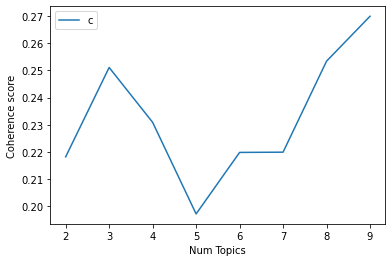

In [ ]:
import matplotlib.pyplot as plt
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
def compute_perplexity_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v perplexity for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    perplexity_values : Perplexity values corresponding to the LDA model with respective number of topics
    """
    
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        perplexity_values.append(model.log_perplexity(corpus))

    return model_list, perplexity_values

model_list, perplexity_values = compute_perplexity_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=10, step=1)

In [ ]:
perplexity_values[2]

-8.193039290024437

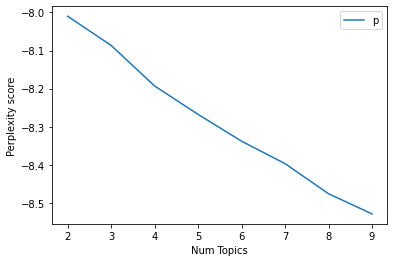

In [ ]:
import matplotlib.pyplot as plt
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

Согласно графикам выберем количество тем равное 2

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 5 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.027*"india" + 0.021*"market" + 0.015*"insurance" + 0.015*"rbi" + 0.015*"reserve" + 0.009*"life" + 0.008*"report" + 0.008*"government" + 0.008*"company" + 0.007*"foreign"'), (1, '0.044*"r" + 0.036*"crore" + 0.027*"per" + 0.022*"rate" + 0.017*"state" + 0.015*"net" + 0.015*"loan" + 0.015*"sector" + 0.013*"credit" + 0.012*"year"')]


In [ ]:
# pyLDAvis - LDA visualisation
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 7.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7f42b1aa840495c23b0e2e2dd1ae84853066c214f3e828c0d5c6cdf93a8a3770
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
# import pyLDAvis.gensim as gensimvis
#pyLDAvis.enable_notebook()

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# Visualize the topics
pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.239298  0.0       1        1  62.171112
1     -0.239298  0.0       2        1  37.828888, topic_info=       Term         Freq        Total Category  logprob  loglift
37        r  8182.000000  8182.000000  Default  30.0000  30.0000
29    crore  6637.000000  6637.000000  Default  29.0000  29.0000
6       per  5059.000000  5059.000000  Default  28.0000  28.0000
51     rate  3969.000000  3969.000000  Default  27.0000  27.0000
312   state  3122.000000  3122.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
10      cut   949.859593   951.776215   Topic2  -5.2684   0.9701
269    idbi  1742.463348  1760.940074   Topic2  -4.6617   0.9615
177    bond  1239.411781  2103.110467   Topic2  -5.0023   0.4433
1030   plan  1057.938434  2659.112083   Topic2  -5.1607   0.0504
4     india  1059.171770  9295.696274   Topic2  -5.1595  -1.2000

[115 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
227       1  0.999450  banking
227       2  0.000559  banking
707       1  0.998943    board
707       2  0.001279    board
177       1  0.410820     bond
...     ...       ...      ...
14        2  0.001163     take
39        1  0.000466     year
39        2  0.999697     year
184       1  0.001821    yield
184       2  0.998990    yield

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

1)Новости про политику, влияние других государств, займы, кредиты, страхование  2) Новости по анализу того, что было проделано в финансовой сфере, какие результы и планы



Вывод: Выполнено тематическое моделирование финансовых новостей в Индии, были получены 2 темы, которая подобрана по графиками оценок perplexity и coherence. Среди того, что нужно улучшить могу отметить, что можно больше поработать над тем, чтобы убрать стоп-слова касательно именно данного направления (и постараться убрать их после нормализации, чтобы очистить все формы данного слова).